# Exercise 8 - Basic Samplers

In this exercise, we will build samplers to generate samples from categoricals and gaussians.

In the event of a persistent problem, do not hesitate to contact the course instructors under
- paul.kahlmeyer@uni-jena.de

### Submission

- Deadline of submission:
        08.01.2023
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=34630)

### Help
In case you cannot solve a task, you can use the saved values within the `help` directory:
- Load arrays with [Numpy](https://numpy.org/doc/stable/reference/generated/numpy.load.html)
```
np.load('help/array_name.npy')
```
- Load functions, classes and other objects with [Dill](https://dill.readthedocs.io/en/latest/dill.html)
```
import dill
with open('help/some_func.pkl', 'rb') as f:
    func = dill.load(f)
```

to continue working on the other tasks.

# Sampling from Distributions

Sampling from a distribution is mostly done by mapping the unit interval $[0, 1]$ onto the sampling space of the distribution. If we then have a sampler on the unit interval, we can map these samples onto the target sample space.

How to sample from $[0,1]$ was the content of the last exercise. In this exercise we will leave sampling from $[0, 1]$ to [Numpy](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html).

## Categorical

Transforming samples from $[0, 1]$ into categories of a categorical with probability vector $p$ is done with **Inverse Transform Sampling**:

We split the interval into bins of size $p(x=i)$ for each category $i$.
Then we can assign each $u\in[0, 1]$ to the category of the bin it falls into. 

The following figure illustrates this process for 4 categories. The blue balls are samples in $[0, 1]$ and fall into bins that are of the width of the respective category. 
<div>
<img src="images/its.png" width="600"/>
</div>



### Task 1

Implement the inverse transform sampling for categoricals.

Use this function to sample from a categorical with 
\begin{equation}
p = [0.1, 0.2 , 0.1, 0.15 , 0.13, 0.32]^T
\end{equation}

and compare the true $p$ to the maximum likelihood estimate based on an increasing number of samples over 10 tries.

For visualization you can use the calculation of a mean confidence interval in `utils.py`.

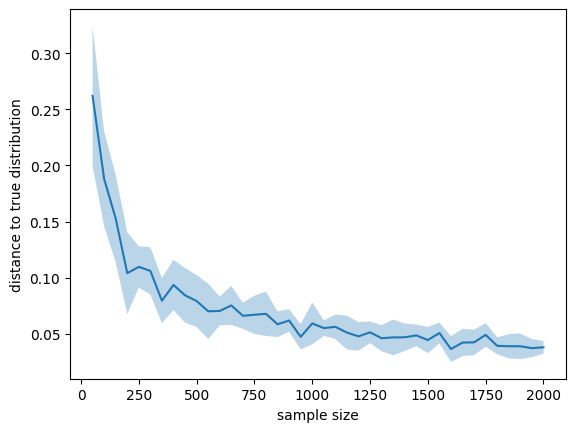

In [47]:
import numpy as np
import matplotlib.pyplot as plt

import utils


def sample_categorical(p: np.ndarray, N: int = 1) -> np.ndarray:
    '''
    Samples from a categorical. 

    @Params:
        p... probability vector
        N... number of samples

    @Returns:
        samples from a categorical distribution
    '''

    cum = np.cumsum(p)
    unif_samples = np.random.rand(N)
    return np.array([np.where(unif_sample <= cum)[0][0] for unif_sample in unif_samples])


def frequencies(samples: np.ndarray, sample_space_size: int) -> np.ndarray:
    return np.array([np.count_nonzero(samples == x) for x in range(sample_space_size)]) / len(samples)


def distance_measure(p_1: np.ndarray, p_2: np.ndarray) -> float:
    # use 1-norm as distance measure between distributions
    return np.sum(np.abs(p_1 - p_2))


p_true = np.array([0.1, 0.2, 0.1, 0.15, 0.13, 0.32])
# TODO: compare estimate to truth for increasing number of samples
n_runs = 10
sample_space_size = len(p_true)
min_sample_size = 50
max_sample_size = 2000
sample_size_steps = 50
sample_sizes = range(min_sample_size, max_sample_size + 1, sample_size_steps)

# sample a bunch of times and save the errors
errors = np.empty((len(sample_sizes), n_runs))
for sample_size_idx, sample_size in enumerate(sample_sizes):
    for run in range(n_runs):
        samples = sample_categorical(p_true, sample_size)
        ml_estimate = frequencies(samples, sample_space_size)
        errors[sample_size_idx, run] = distance_measure(p_true, ml_estimate)

# plot mean error with confidence intervals
confidence_intervals = np.array([utils.mean_confidence_interval(run) for run in errors])
mean_errors = confidence_intervals[:, 0]
lower_bound_errors = confidence_intervals[:, 1]
upper_bound_errors = confidence_intervals[:, 2]
plt.plot(sample_sizes, mean_errors)
plt.fill_between(sample_sizes, lower_bound_errors, upper_bound_errors, alpha=0.3)
plt.xlabel("sample size")
plt.ylabel("distance to true distribution")
plt.show()


## Standard Normal Distribution

The  [Box Muller Transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) is a method to transform samples $u, v \in[0, 1]^2$ into samples $x_0, x_1$ from a standard normal distribution $\mathcal{N}(0, 1)$. 

This is done by treating $u$ and $v$ as probabilities for sampling a point $x_1, x_2$ of a bivariate standard normal distribution with an angle $\theta$ and a distance $r$ from the origin. 

<div>
<img src="images/boxmuller.png" width="200"/>
</div>

We transform $u$ and $v$ to actual $\hat{\theta}$ and $\hat{r}$ by using the [inverse cumulative density function](https://en.wikipedia.org/wiki/Quantile_function):

1. The angle $\theta$ is uniformly distributed in $[0, 2\pi]$.\
We transform $u$ to $\hat{\theta}$ using  $p\left(\theta < \hat{\theta}\right) = \text{cdf}(\hat{\theta})= u$.
2. The half squared distance $\frac{r^2}{2}$ from the origin is exponentially distributed with $\lambda = 1$.\
We transform $v$ to $\frac{\hat{r}^2}{2}$ using $p\left(\frac{r^2}{2} < \frac{\hat{r}^2}{2}\right) = \text{cdf}\left(\frac{\hat{r}^2}{2}\right)= v$


### Task 2

Derive the formulas to calculate $\hat{\theta}$ and $\hat{r}$ from $u$ and $v$.

Based on that, calculate $x_0$ and $x_1$ from $u = 0.5, v = 0.2$.

**TODO:** derive formulas (write them down)

Derive $u \rightarrow \hat{\theta}$:
\begin{align*}
    u &= p(\theta < \hat{\theta})\\
    &= \int_{0}^{\hat{\theta}} \frac{1}{2\pi}\,dx\\
    &= \frac{\hat{\theta}}{2\pi}\\
    \iff \hat{\theta} &= 2\pi u
\end{align*}

Derive $v \rightarrow \frac{\hat{r}^2}{2}$:
\begin{align*}
    v &= p(\frac{r^2}{2} < \frac{\hat{r}^2}{2})\\
    &= \int_{0}^{\frac{\hat{r}^2}{2}} e^{-x}\,dx\\
    &= 1 - e^{-\frac{\hat{r}^2}{2}}\\
    \iff \frac{\hat{r}^2}{2} &= -\log (1 - v)\\
    \iff \hat{r} &= \sqrt{-2 \cdot \log (1 - v)}\\
\end{align*}

In [21]:
def box_muller_transform(u: float, v: float) -> tuple[float, float]:
    theta = 2 * np.pi * u
    r = np.sqrt(-2 * np.log(1 - v))
    x0 = r * np.cos(theta)
    x1 = r * np.sin(theta)
    return x0, x1


u, v = 0.5, 0.2
# TODO: calculate x0, x1
x0, x1 = box_muller_transform(u, v)
print(f"x0: {x0}\nx1: {x1}")


x0: -0.6680472308365775
x1: 8.181219029232676e-17


### Task 3

Implement the sampling process for the standard normal distribution.

Sample 10000 samples.and check the hypothesis that they are distributed according to a standard normal distribution using the [Kolmogorov- Smirnov Test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html) .

We choose a confidence level of 95%; that is, we will reject the null hypothesis (our data is standard normal distributed) in favor of the alternative if the p-value is less than 0.05.

In [33]:
from scipy import stats


def sample_standard_normal(N: int = 1) -> np.ndarray:
    '''
    Samples from a univariate standard normal distribution using Box-Muller transform.

    @Params:
        N... number of samples

    @Returns:
        Samples from a standard normal distribution
    '''

    samples = []
    for i in range(N):
        if i % 2 == 0:
            u, v = np.random.rand(2)
            sample_1, sample_2 = box_muller_transform(u, v)
            samples.append(sample_1)
        else:
            samples.append(sample_2)
    return np.array(samples)


# TODO: sample 10000 samples, check with Kolmogorov Smirnov Test
n_samples = 10000
n_runs = 10
p_values = [None] * n_runs
for run in range(n_runs):
    samples = sample_standard_normal(n_samples)
    test_result = stats.kstest(samples, stats.norm.cdf)
    p_values[run] = test_result.pvalue
print(f"average: p = {np.average(p_values)}")


average: p = 0.5523295465002123


## Arbitrary Gaussian
Now we want to sample from an arbitrary, multivariate gaussian with mean vector $\mu$ and covariance matrix $\Sigma$.


Let $X = (X_1,\dots, X_n)$ be a vector of random variables $X_i$, whose joint density is a **standard** multivariate Gaussian. That is $X\sim\mathcal{N}(0, \mathbb{1}_n)$.

Then for a given mean vector $\mu$ and a convariance matrix with [Cholesky decomposition](https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html) $\Sigma = AA^T$ we can transform $X$ into 
\begin{equation}
Y = AX + \mu
\end{equation}
and $Y\sim\mathcal{N}(\mu, \Sigma)$
### Task 4

Implement the sampling routine to sample from a multivariate Gaussian with given mean and covariance matrix.

Similar to Task 1, use this function to sample from a Gaussian with 
\begin{align}
    \mu &= [5, 2]^T\\
    \Sigma &= \begin{bmatrix}
    2.5 & 1.65\\
    1.65 & 1.93
    \end{bmatrix}\\
\end{align}

and compare the true $\mu$ and $\Sigma$ to the maximum likelihood estimates based on an increasing number of samples over 10 tries.

For visualization you can use the calculation of a mean confidence interval in `utils.py`.

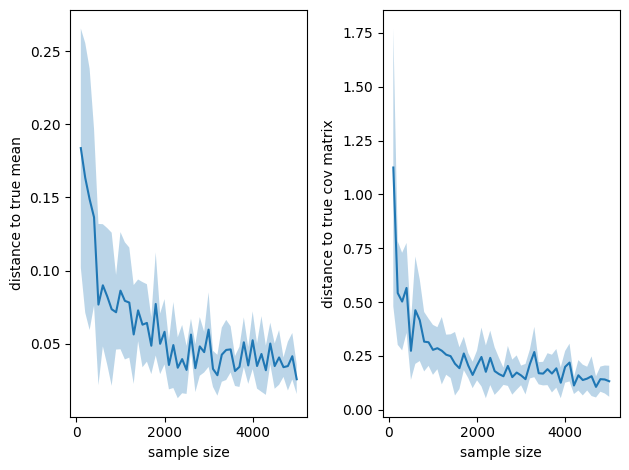

In [59]:
def sample_normal(mean: np.ndarray, cov: np.ndarray, N: int = 1) -> np.ndarray:
    '''
    Samples from a multivariate normal distribution.

    @Params:
        mean... mean vector of gaussian
        cov... covariance matrix
        N... number of samples

    @Returns:
        samples from an arbitrary normal distribution
    '''

    d = mean.shape[0]
    L = np.linalg.cholesky(cov)
    return np.array([L @ sample_standard_normal(d) + mean for _ in range(N)])


# TODO: compare estimate to truth for increasing number of samples
mean_true = np.array([5, 2])
cov_true = np.array([[2.5, 1.65], [1.65, 1.93]])

n_runs = 10
sample_space_size = len(p_true)
min_sample_size = 100
max_sample_size = 5000
sample_size_steps = 100
sample_sizes = range(min_sample_size, max_sample_size + 1, sample_size_steps)

# sample a bunch of times and save the errors
ml_mean_errors = np.empty((len(sample_sizes), n_runs))
ml_cov_errors = np.empty((len(sample_sizes), n_runs))
for sample_size_idx, sample_size in enumerate(sample_sizes):
    for run in range(n_runs):
        samples = sample_normal(mean_true, cov_true, sample_size)
        ml_mean = np.mean(samples, axis=0)
        ml_cov = np.cov(samples.T)
        ml_mean_errors[sample_size_idx, run] = np.sum(np.abs(ml_mean - mean_true))
        ml_cov_errors[sample_size_idx, run] = np.sum(np.abs(ml_cov - cov_true))

# plot mean error with confidence intervals
# mean
plt.subplot(121)
confidence_intervals = np.array([utils.mean_confidence_interval(run) for run in ml_mean_errors])
mean_errors = confidence_intervals[:, 0]
lower_bound_errors = confidence_intervals[:, 1]
upper_bound_errors = confidence_intervals[:, 2]
plt.plot(sample_sizes, mean_errors)
plt.fill_between(sample_sizes, lower_bound_errors, upper_bound_errors, alpha=0.3)
plt.xlabel("sample size")
plt.ylabel("distance to true mean")
# cov
plt.subplot(122)
confidence_intervals = np.array([utils.mean_confidence_interval(run) for run in ml_cov_errors])
mean_errors = confidence_intervals[:, 0]
lower_bound_errors = confidence_intervals[:, 1]
upper_bound_errors = confidence_intervals[:, 2]
plt.plot(sample_sizes, mean_errors)
plt.fill_between(sample_sizes, lower_bound_errors, upper_bound_errors, alpha=0.3)
plt.xlabel("sample size")
plt.ylabel("distance to true cov matrix")

plt.tight_layout()
plt.show()
